# Comparative Study of Car License Plate Detection using YOLO and FastRCNN Models
Recently there has been a rise on the use of technology to automatic many applications in various sectors. This project is one of them. It aims to evaluate and compare the performance of two object detection models, YOLO (You Only Look Once) and Fast R-CNN (Regions with CNN features), for a task on car license plate detection. Having a very accurate and efficient license plate detection is very important for many applications in any jurisdiction i.e, automated toll collection, parking management, tracking movement, vehicle counts, and law enforcement. This study seeks to identify which model offers the best balance between speed and accuracy across different datasets.

Most state-of-the-art systems face an issue of balancing the trade-off between high accuracy and real-time processing speed. As different object detection models have distinct performance characteristics, it is indispensable to identify which model is optimal for a certain deployment scenario. This project explores and compares the performance of two well-known object detection models, namely YOLO and Fast R-CNN. YOLO is very fast and efficient, hence applicable for real-time applications. This network processes an entire image with one pass, predicting all bounding boxes and classes in one shot.

Fast R-CNN has two stages where it proposes first and then classifies, hence offering higher accuracy. Due to this two-stage, it is somehow heavy in computation.

In this project, by comparing YOLO and Fast R-CNN, it tries to find out which model offers the best balance between performance and efficiency for real-time car license plate detection on different datasets. It will take into consideration some key factors like accuracy of detection, speed of processing, and requirements of computational resources. Dataset

The dataset originates from the research associated with the GitHub repository Real-time Auto License Plate Recognition with Jetson Nano. Its main purpose is for training machine learning models for automatic licence plate detection. It has information like images of vehicles and license plates, likely with bounding box annotations for supervised learning tasks. The dataset contains image data in png format, specifically images of vehicles and license plates used for recognition tasks. The images are annotated for the licence plate bounding information which will be used as supervision for our training.

## Project Development Approach
The implementation will be following a defined approach in order to come up with final comparison results between YOLO and Fast R-CNN models hence accomplishing the car license plate detection. The major steps involved are data pre-processing, model training, performance evaluation, and speed assessment.

* First, the original dataset from the Real-time Auto License Plate Recognition with Jetson Nano GitHub repository will be considered. These bounding box annotations should be translated into a format required by each model; this may include normalizing the coordinates and compatibility with the input format of YOLO and Fast R-CNN.

* Then, the preprocessed dataset will be used to train YOLO and Fast R-CNN. Here, pre-trained weights will be used through transfer learning, which enables faster training and higher performance. The validation set will be used for hyperparameter tuning in order to optimize the model’s performance. On this a loss function will also be used for detection tasks on bounding box regression, to monitor the training process.

* The performance of the trained models will be measured by standard object detection metrics.

* Intersection over Union - It refers to the measurement of overlapping between predicted and ground truth bounding boxes. Mean Average Precision-mAP@XX - The accuracy of the models shall be measured using mAP. Therefore, the mAP@50-IoU threshold of 0.5-and mAP@75-IoU threshold of 0.75-will be calculated to give an overall view regarding how the model performs at different IoU thresholds.
* Precision and Recall - These two metrics will be used in analyzing the trade-off between false positives and false negatives.
* The speeds of the models will be decided by measuring the time of inference on a dedicated hardware setup. Inference time will be calculated as the average time taken by a model to process one image. This apart, FPS will also be calculated to provide real-time performance metrics.

* The results from performance and speed evaluation will be drawn together to conclude which model gives the best combination of accuracy and efficiency for real-time car license plate detection.

# Project AIM
The main aim for the project is to conduct a computer vision based model training for detection of vehicle licences and then compare the performances and efficiency for real-time car license plate detection for YOLO and FastRCNN models.

# Project Objectives
* To study and review relevant papers concerning object detection models with a bias toward license plate detection to understand the current trends and best practices in the field.
* To clean and pre-process the car license plate dataset to make it ready for training.
* To train both YOLO and Fast R-CNN models using the prepared dataset, optimizing each for accurate license plate detection.
* To perform a comparative study of the YOLO and Fast R-CNN models in detecting license plates. Based on the accuracy, speed, and overall efficiency, access and compare models.
* To evaluate the performance of the trained models using relevant performance metrics. and later compile a comprehensive final report summarizing the methodology, analysis, results, and conclusions of the project.

In [2]:
# install first coco related modules
!pip install pycocotools -q
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

fatal: destination path 'vision' already exists and is not an empty directory.
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [3]:
# system setup
import os
import shutil
import glob
import time
import subprocess
import gc


# data hadnle
import json
import yaml
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# img and vis 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image as PILImage
from matplotlib.patches import Rectangle
from IPython.display import display, HTML, Image

# torch and torchvision
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# COCO-related Modules
from pycocotools.coco import COCO
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset

# train and eval Functions
from engine import train_one_epoch, evaluate

# 
# 
from tqdm import tqdm


In [4]:
os.listdir("/kaggle/input/yolo-plate-dataset")

['yolo_plate_dataset']

In [5]:
len(os.listdir("/kaggle/input/yolo-plate-dataset/yolo_plate_dataset"))//2

8260

In [6]:
# we need to get all images and their corresponding labels into csv in order to visualized some samples.
# the data is already in yolo format, and we will need to change it also for fastercnn
# Yolo data looks as < obj-ID> <x_center> <y_center> <bbox_width> <bbox_height>

In [7]:
BASE_DIR = "/kaggle/input/yolo-plate-dataset/yolo_plate_dataset"

In [10]:
# lets check an example
open(f"{BASE_DIR}/CarLongPlate100.txt").read().split("\n ")

['0 0.550847 0.599010 0.224576 0.089109\n']

In [11]:
def yolo_to_csv(data_path, output_csv):
    data = []
    # we iterate everything
    for idx, label_file in enumerate(os.listdir(data_path)):
        if label_file.endswith('.txt'):
            # get the corresponding image file
            image_file = label_file.replace('.txt', '.jpg')
            
            # full path to the label file and the image file
            label_path = os.path.join(data_path, label_file)
            image_path = os.path.join(data_path, image_file)
            
            # check if the image exists
            if os.path.exists(image_path):

                #read image to get the sizes, we will use h,w to un-normalize the labels
                with PILImage.open(image_path) as img:
                    image_width, image_height = img.size
                
                # read the labels
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    
                    # get the data for it through each object in the label file
                    for line in lines:
                        # split the line by space into components
                        parts = line.strip().split()
                        
                        if len(parts) == 5:
                            class_id, x_center, y_center, width, height = map(float, parts)

                            # Calculate unnormalized coordinates
                            x_center_unormalized = x_center * image_width
                            y_center_unormalized = y_center * image_height
                            width_unormalized = width * image_width
                            height_unormalized = height * image_height
                            
                            # Calculate bounding box corners
                            x_min = x_center_unormalized - (width_unormalized / 2)
                            y_min = y_center_unormalized - (height_unormalized / 2)
                            x_max = x_center_unormalized + (width_unormalized / 2)
                            y_max = y_center_unormalized + (height_unormalized / 2)

                            
                            data.append([image_file, int(class_id), x_center, y_center, width, height,x_min, y_min, x_max, y_max, image_width, image_height])
    
    # create a df
    df = pd.DataFrame(data, columns=['image_filename', 'class_id', 'x_center', 'y_center', 'bbox_width', 'bbox_height', 'x_min', 'y_min', 'x_max', 'y_max', 'image_width','image_height',])
    
    df.to_csv(output_csv, index=False)
    print(f"CSV saved to {output_csv}")

yolo_to_csv(f"{BASE_DIR}", "labels.csv")

CSV saved to labels.csv


In [13]:
df = pd.read_csv("labels.csv")
df.head(8)

,image_filename,class_id,x_center,y_center,bbox_width,bbox_height,x_min,y_min,x_max,y_max,image_width,image_height
0,CarLongPlateGen2621.jpg,0,0.403602,0.534653,0.290254,0.125413,122.000200,142.999790,259.000088,180.999929,472,303
1,CarLongPlate708.jpg,0,0.355932,0.841584,0.224576,0.099010,114.999968,239.999937,220.999840,269.999967,472,303
2,xemay1617.jpg,0,0.455508,0.397690,0.182203,0.240924,171.999868,84.000084,257.999684,157.000056,472,303
3,ngoaigiao10.jpg,0,0.336268,0.634831,0.109155,0.123596,80.000102,101.999874,111.000122,123.999962,284,178
4,CarLongPlateGen3435.jpg,0,0.594280,0.549505,0.180085,0.194719,238.000100,137.000087,323.000220,195.999944,472,303
5,xemay1884.jpg,0,0.385593,0.537954,0.105932,0.125413,156.999944,143.999993,206.999848,182.000132,472,303
6,CarLongPlate873.jpg,0,0.453390,0.661716,0.228814,0.089109,159.999976,186.999934,268.000184,213.999962,472,303
7,CarLongPlateGen1893.jpg,0,0.425847,0.405941,0.228814,0.112211,146.999680,106.000157,254.999888,140.000090,472,303


In [14]:
df.class_id.unique()

array([0])

In [15]:
def plot_licence_plates_bbox(image_name):
    
    fig, ax = plt.subplots(1, 2, figsize = (14, 14))
    ax = ax.flatten()
    
    bbox = df[df['image_filename'] == image_name]
    img_path = f"{BASE_DIR}/{image_name}"
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image
    
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
    for idx, row in bbox.iterrows():
        x1 = row['x_min']
        y1 = row['y_min']
        x2 = row['x_max']
        y2 = row['y_max']
        label = row['class_id']
        color_brg = (255,0,0)
        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), (255,0,0), 2)
    
    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

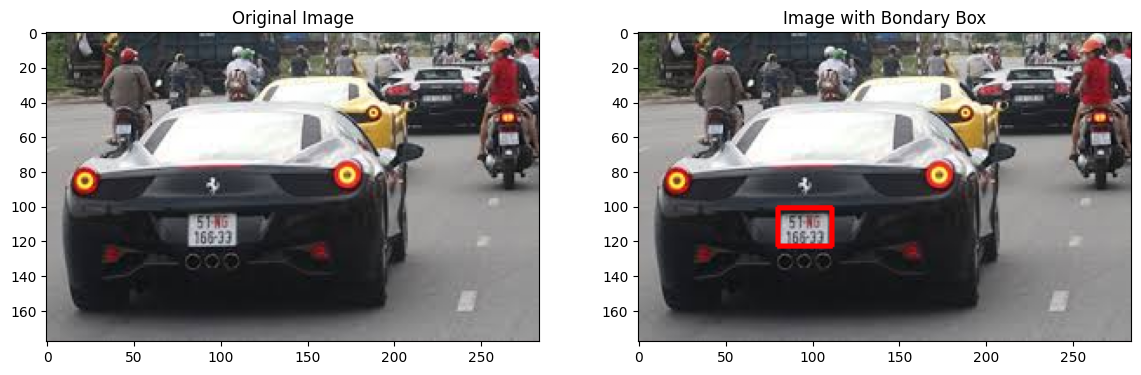

In [16]:
plot_licence_plates_bbox("ngoaigiao10.jpg")

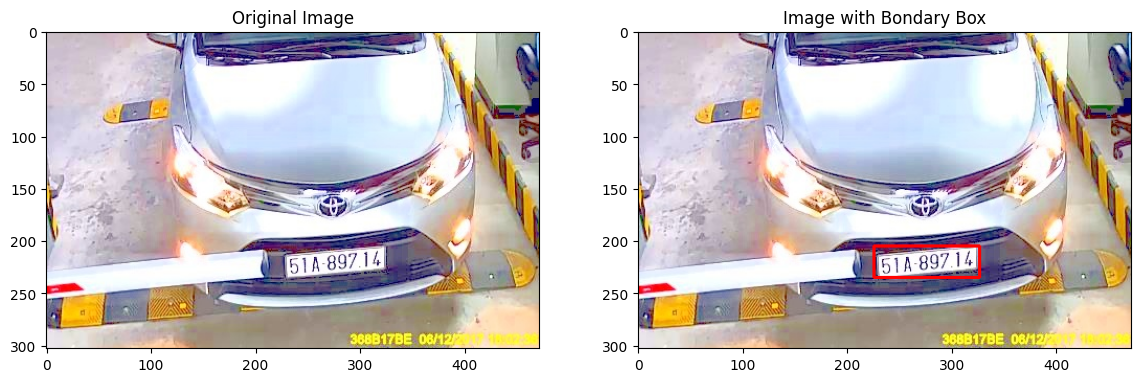

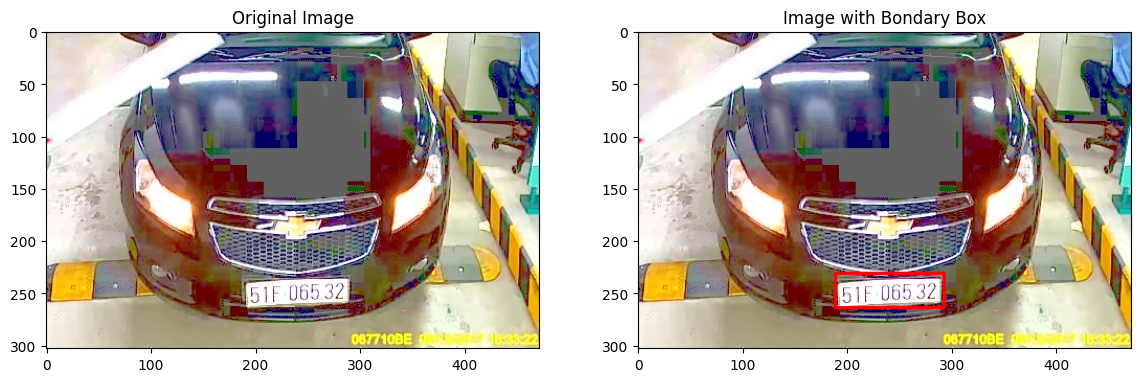

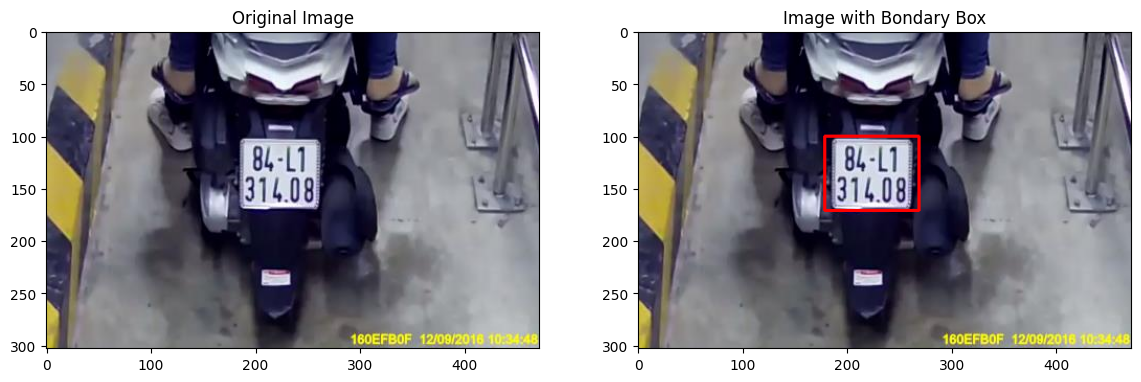

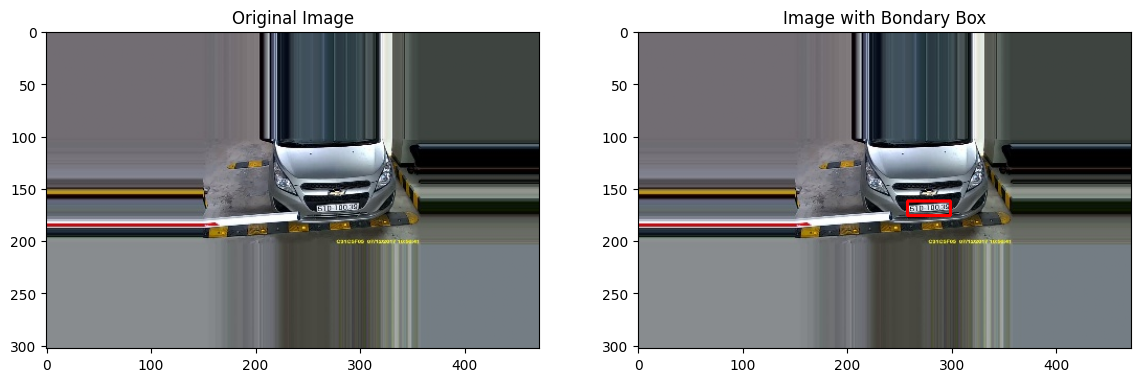

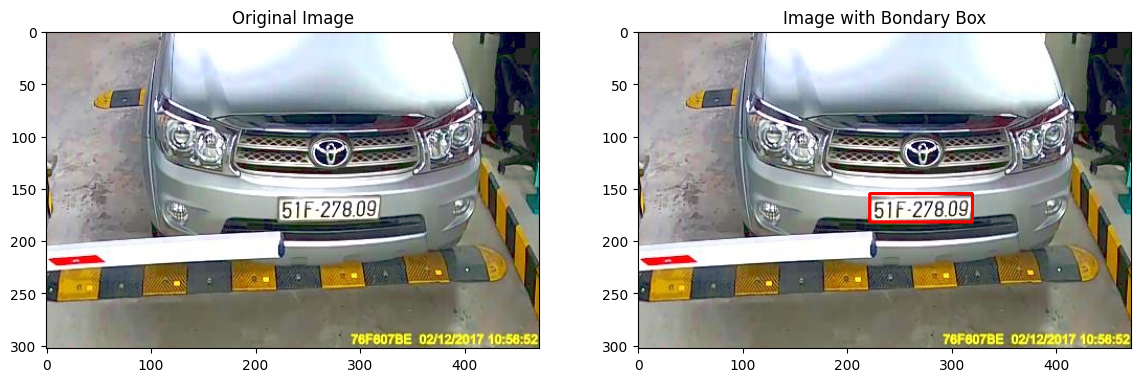

In [17]:
for each_filename in df.sample(5)["image_filename"].values:
    plot_licence_plates_bbox(each_filename)

In [18]:
unq_values = df["image_filename"].unique()
print("Total Records: ", len(df))
print("Unique Images: ",len(unq_values))

null_values = df.isnull().sum(axis = 0)
print("\n> Null Values in each column <")
print(null_values)

Total Records:  8452
Unique Images:  8259

> Null Values in each column <
image_filename    0
class_id          0
x_center          0
y_center          0
bbox_width        0
bbox_height       0
x_min             0
y_min             0
x_max             0
y_max             0
image_width       0
image_height      0
dtype: int64


In [19]:
classes = df["class_id"].unique()
print("Total Classes: ",len(classes))
print("\n> Classes <\n",classes)

Total Classes:  1

> Classes <
 [0]


In [20]:
df.groupby("image_filename").count()

,class_id,x_center,y_center,bbox_width,bbox_height,x_min,y_min,x_max,y_max,image_width,image_height
image_filename,,,,,,,,,,,
CarLongPlate0.jpg,1,1,1,1,1,1,1,1,1,1,1
CarLongPlate1.jpg,1,1,1,1,1,1,1,1,1,1,1
CarLongPlate10.jpg,1,1,1,1,1,1,1,1,1,1,1
CarLongPlate100.jpg,1,1,1,1,1,1,1,1,1,1,1
CarLongPlate101.jpg,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
xemayBigPlate95.jpg,1,1,1,1,1,1,1,1,1,1,1
xemayBigPlate96.jpg,1,1,1,1,1,1,1,1,1,1,1
xemayBigPlate97.jpg,1,1,1,1,1,1,1,1,1,1,1


# Preparing Dataset for Training
## Training Faster R-CNN Model on License Plate Detection
**Faster R-CNN** (Region-based Convolutional Neural Networks) mainly combines **Region Proposal Networks** (RPN) with Fast R-CNN in order to achieve faster and more precise detection.
It generates region proposals and classifies these regions into object categories while refining their bounding boxes, making it ideal for detecting objects like license plates in traffic images.
## Data Preparation for Faster R-CNN Model
The data for Faster R-CNN needs to be prepared in a specific format that includes images and corresponding annotations in a structured way. For this project, we aim to detect license plates, so the dataset should include images with license plates and their corresponding bounding boxes.

The annotation should follow the **COCO format**, which includes information about the objects present in the image such as bounding boxes, labels, areas, and other necessary details. In our case, the object label will be **"license plate"**.

For each image, the target should include:

1. **boxes** : A tensor containing the bounding box coordinates for each object (license plate) in the image. These boxes are in the format [x_min, y_min, x_max, y_max].
2. **labels** : A tensor containing the class labels for each bounding box. For license plate detection, we will have a label of 1 representing the license plate class (background will have the label 0).
3. **area** : A tensor containing the area of each bounding box. This is the width multiplied by the height of the bounding box.
4. **image_id** : A unique identifier for the image. This helps when evaluating the performance and tracking predictions per image.
5. **iscrowd** : An array indicating whether each bounding box contains a crowd of objects. In our case, all will be FALSE, as we expect each image to contain only one license plate.
We will use a custom data loader, which converts this data into the format expected by Faster R-CNN. Using a data class from **torch** will help to structure this dataset and make it ready for training.

In [21]:
df.head(2)

,image_filename,class_id,x_center,y_center,bbox_width,bbox_height,x_min,y_min,x_max,y_max,image_width,image_height
0,CarLongPlateGen2621.jpg,0,0.403602,0.534653,0.290254,0.125413,122.000200,142.999790,259.000088,180.999929,472,303
1,CarLongPlate708.jpg,0,0.355932,0.841584,0.224576,0.099010,114.999968,239.999937,220.999840,269.999967,472,303


In [22]:
# prepare data for Train & Validation
def get_transform():
    return T.Compose([T.ToTensor()])

def collate_fn(batch):
    return tuple(zip(*batch))

In [23]:
class LicensePlateDetectionDataset(Dataset):
    def __init__(self, df, img_dir, transforms=None):
        self.df = df
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_filename'])
        image = PILImage.open(img_path).convert("RGB")

        #bounding box information
        x_center = row['x_center'] * row['image_width']
        y_center = row['y_center'] * row['image_height']
        bbox_width = row['bbox_width'] * row['image_width']
        bbox_height = row['bbox_height'] * row['image_height']
        
        # convert to xmin, ymin, xmax, ymax
        x_min = x_center - bbox_width / 2
        y_min = y_center - bbox_height / 2
        x_max = x_center + bbox_width / 2
        y_max = y_center + bbox_height / 2
        
        # bboxt and labels
        boxes = torch.tensor([[x_min, y_min, x_max, y_max]], dtype=torch.float32)
        labels = torch.tensor([row['class_id']], dtype=torch.int64)
        
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": row['image_filename'],
            "area": torch.tensor([bbox_width * bbox_height], dtype=torch.float32),
            "iscrowd": torch.zeros(len(boxes), dtype=torch.int64)
        }

        # app transformations if any
        if self.transforms:
            image = self.transforms(image)

        return image, target

In [24]:
def split_dataset(df, test_size=0.2, random_state=42):
    """
    Splits the dataframe into training and testing sets based on unique image filenames.
    """
    
    # get unique image filenames
    unique_filenames = df['image_filename'].unique()
    
    # splot unique filenames into training and testing sets
    train_filenames, test_filenames = train_test_split(
        unique_filenames, test_size=test_size, random_state=random_state
    )
    
    # fiilter the original dataframe to get the corresponding rows for training and testing
    train_df = df[df['image_filename'].isin(train_filenames)]
    test_df = df[df['image_filename'].isin(test_filenames)]
    
    return train_df, test_df

In [25]:
df.shape

(8452, 12)

In [26]:
# split train vs test using 80/20 rule
train_df, test_df = split_dataset(
    df.sample(6000), 
    test_size=0.2, 
    random_state=42)

print(f"Train dataset size: {len(train_df)}")
print(f"Test dataset size: {len(test_df)}")

Train dataset size: 4807
Test dataset size: 1193


In [27]:
# Dataset object
train_dataset = LicensePlateDetectionDataset(
    train_df, 
    f"{BASE_DIR}", 
    transforms = get_transform()
)
valid_dataset = LicensePlateDetectionDataset(
    test_df, 
    f"{BASE_DIR}", 
    transforms = get_transform()
)


In [28]:
# train_dataset.background_images

In [29]:
train_dataset[1]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 {'boxes': tensor([[255.9998, 297.9999, 315.9998, 336.0001]]),
  'labels': tensor([0]),
  'image_id': 'rotatequandoi30.jpg',
  'area': tensor([2280.0073]),
  'iscrowd': tensor([0])})

In [30]:
# create data loaders for train
train_data_loader = DataLoader(
    train_dataset,
    batch_size = 5,
    shuffle = True,
    num_workers = 4,
    collate_fn = collate_fn
)

# create data loaders for validatioj
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 5,
    shuffle = False,
    num_workers = 4,
    collate_fn = collate_fn
)

In [31]:
# get the GPU device if available

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

In [32]:
# help(torchvision.models.detection.fasterrcnn_resnet50_fpn)

In [33]:
# no. of classes
# we have only one class: License Plate (class 1), with background as class 0
num_classes =  2 # 1 class (license plate) + 1 background class


# lets load the faster rcnn model
fasterrcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)
# fasterrcnn_model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)


"""This takes alot of time """
# load the Faster R-CNN Model pretrained with  COCO dataset
# # fasterrcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
# weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
# fasterrcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights, pretrained=True)


# # get the number of input features for the classifier (box predictor)
in_features = fasterrcnn_model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained classifier with a new one for our use case
fasterrcnn_model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


# move the model to device
fasterrcnn_model = fasterrcnn_model.to(device)

# get all parameters to be used for training
params = [p for p in fasterrcnn_model.parameters() if p.requires_grad]

# an optimizer
optimizer = torch.optim.Adam(params, lr=0.001)

# optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

# LR scheduler (adjust every 2 epochs)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.001)

In [6]:
# fasterrcnn_model

In [7]:
print("Continuing")

Continuing


In [8]:
# function to save best model 
def update_latest_model(model, epoch, metric_value, filepath):
    # Save model using torch.save or any other method
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'metric_value': metric_value,
    }, filepath)
    print(f"Saved model at epoch {epoch} with metric {metric_value}.")

In [9]:

# fnt to handle the extraction of mAP and AR metrics at different IoU thresholds
def calculate_precision_recall_at_iou(results_evaluator, iou_threshold=0.50):
    task_type = 'bbox'
    bbox_stats = results_evaluator.coco_eval[task_type].stats
    # indx for mAP and AR at specific IoU thresholds
    mAP_index = 0 if iou_threshold == 0.50 else 2
    AR_index = 6 if iou_threshold == 0.50 else 8
    mAP = bbox_stats[mAP_index]
    AR = bbox_stats[AR_index]
    return mAP, AR


# fnt to get all relevant evaluation metrics
def collect_perfomance_results(results_evaluator):
    """
    get all the necessary metrics from the evaluation results.
    """
    mAP_50, AR_50 = calculate_precision_recall_at_iou(results_evaluator, iou_threshold=0.50)
    mAP_95, AR_95 = calculate_precision_recall_at_iou(results_evaluator, iou_threshold=0.95)
    return [mAP_50, AR_50, mAP_95, AR_95]


In [12]:
# init  lists to keep track of training and evaluation metrics
training_metrics = []
testing_metrics = []
NUM_EPOCHS = 15

# for the loss tracking for each epoch
loss_metrics = {
    'classification_loss': [],
    'bounding_box_loss': [],
    'objectness_loss': [],
    'total_loss': [],
    'rpn_bbox_loss': [],
}

# to know the best model epoch
best_loss_value = float('inf')
best_epoch = 0



# for the process of training and evaluatio
def train_and_evaluate_model(model, optimizer, lr_scheduler, train_data_loader, valid_data_loader, device, num_epochs=2):
    global best_loss_value, best_epoch
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        gc.collect()

        # train for one epoch and get loss metrics
        train_loss = train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
        
        # update loss tracking
        loss_metrics['classification_loss'].append(train_loss.meters['loss_classifier'].avg)
        loss_metrics['bounding_box_loss'].append(train_loss.meters['loss_box_reg'].avg)
        loss_metrics['objectness_loss'].append(train_loss.meters['loss_objectness'].avg)
        loss_metrics['total_loss'].append(train_loss.meters['loss'].avg)
        loss_metrics['rpn_bbox_loss'].append(train_loss.meters['loss_rpn_box_reg'].avg)
        
        # update learning rate scheduler
        lr_scheduler.step()
        
        # save the model if it has the best performance so far        
        if train_loss.meters['loss'].avg < best_loss_value:
            best_loss_value = train_loss.meters['loss'].avg
            best_epoch = epoch
            update_latest_model(model, epoch, best_loss_value, f'best_model_epoch_{epoch}.pth')
            
        
        # periodic evaluation on the training and validation datasets
        print(f"Evaluating model after epoch {epoch + 1}...")
        train_evaluator = evaluate(model, train_data_loader, device=device)
        test_evaluator = evaluate(model, valid_data_loader, device=device)

        # extract metrics from evaluation
        train_metrics = collect_perfomance_results(train_evaluator)
        test_metrics = collect_perfomance_results(test_evaluator)

        # stros metrics for later analysis
        training_metrics.append(train_metrics)
        testing_metrics.append(test_metrics)

        print(f"Epoch {epoch + 1} metrics:")
        print(f"Training mAP50: {train_metrics[0]}, AR50: {train_metrics[1]}, mAP95: {train_metrics[2]}, AR95: {train_metrics[3]}")
        print(f"Testing mAP50: {test_metrics[0]}, AR50: {test_metrics[1]}, mAP95: {test_metrics[2]}, AR95: {test_metrics[3]}")

    print(f"Best model saved at epoch {best_epoch} with loss {best_loss_value}")


# perfom the training
train_and_evaluate_model(fasterrcnn_model, optimizer, lr_scheduler, train_data_loader, valid_data_loader, device, NUM_EPOCHS)

NameError: name 'fasterrcnn_model' is not defined

# Perfomance and Loss Evaluation

In [2]:
# p,ot the losses
def plot_losses_grid(loss_data, titles, labels, colors, ncols, suptitle, figsize=(18, 6)):
    """
    plottig losses
    """
    nrows = (len(loss_data) + ncols - 1) // ncols 
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axs = axs.flatten() if nrows > 1 else axs
    
    # iterate through each loss type and plot
    for i, (loss_type, loss_values) in enumerate(loss_data.items()):
        axs[i].plot(loss_values, color=colors[i], marker='o', label=labels[i])
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel(loss_type)
        axs[i].set_title(titles[i])
        axs[i].legend()

    plt.suptitle(suptitle, fontweight='bold', fontsize=17)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
    plt.show()

In [3]:
loss_metrics.keys()

NameError: name 'loss_metrics' is not defined

In [4]:
# get for classification losses
classification_losses = {
    'class_losses': loss_metrics['classification_loss'],
    'total_loss': loss_metrics['total_loss'],
    'loss_rpn_box_reg': loss_metrics['rpn_bbox_loss'],
}

# define title, colors and labels
classification_titles = ['Training Class Loss', 'Total Loss', 'RPN Box Regression Loss']
classification_labels = ['Train Class Loss', 'Total Loss', 'RPN Box Regression Loss']
classification_colors = ['blue', 'red', 'green']

# plot classification losses
plot_losses_grid(
    loss_data=classification_losses,
    titles=classification_titles,
    labels=classification_labels,
    colors=classification_colors,
    ncols=3,
    suptitle='Training Losses Metrics Related to Classification'
)


NameError: name 'loss_metrics' is not defined

In [ ]:
# Data for training losses based on the provided results
train_losses = {
    'obj_loss': [0.1251, 0.0508, 0.0363, 0.0264, 0.0210, 0.0176],  # Objective loss
    'box_loss': [0.0031, 0.0048, 0.0042, 0.0038, 0.0035, 0.0033],   # Box regression loss
}

# Data for object detection losses
object_detection_losses = {
    'obj_loss': train_losses['obj_loss'],
    'box_loss': train_losses['box_loss'],
}

# Titles for object detection losses
object_detection_titles = ['Objective Loss', 'Box Regression Loss']

# Labels for object detection losses
object_detection_labels = ['Objective Loss', 'Box Regression Loss']

# Colors for object detection losses
object_detection_colors = ['magenta', 'yellow']

# Plot object detection losses (1x2 grid)
plot_losses_grid(
    loss_data=object_detection_losses,
    titles=object_detection_titles,
    labels=object_detection_labels,
    colors=object_detection_colors,
    ncols=2,
    suptitle='Training Losses Metrics Related to Object Detection'
)


In [ ]:

epochs = np.arange(1, len(training_metrics)+1)
epochs


In [ ]:
# this will plot recall/precison
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

# mAP_50 Precision
axs[0].plot(epochs, [m[0] for m in training_metrics], marker='o', color='b', label='mAP_50 (Train)')
axs[0].plot(epochs, [m[0] for m in testing_metrics], marker='o', color='r', label='mAP_50 (Test)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('mAP_50')
axs[0].set_title('mAP_50 Precision Comparison', fontweight='bold', fontsize=15)
axs[0].legend()

# mAP_95 Precision
axs[1].plot(epochs, [m[2] for m in training_metrics], marker='o', color='b', label='mAP_95 (Train)')
axs[1].plot(epochs, [m[2] for m in testing_metrics], marker='o', color='r', label='mAP_95 (Test)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('mAP_95')
axs[1].set_title('mAP_95 Precision Comparison', fontweight='bold', fontsize=15)
axs[1].legend()
plt.suptitle(f"Precision Comparison at ious=[0.5 and 0.95]", fontweight='bold', fontsize=17)
plt.tight_layout()
plt.show()

In [ ]:
epochs

In [ ]:
# plt  Comparison for AR_50 and AR_95
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

#  AR_50 Recall
axs[0].plot(epochs, [m[1] for m in training_metrics], marker='o', color='b', label='AR_50 (Train)')
axs[0].plot(epochs, [m[1] for m in testing_metrics], marker='o', color='r', label='AR_50 (Test)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('AR_50')
axs[0].set_title('AR_50 Recall Comparison', fontweight='bold', fontsize=15)
axs[0].legend()

#  AR_95 Recall
axs[1].plot(epochs, [m[3] for m in training_metrics], marker='o', color='b', label='AR_95 (Train)')
axs[1].plot(epochs, [m[3] for m in testing_metrics], marker='o', color='r', label='AR_95 (Test)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('AR_95')
axs[1].set_title('AR_95 Recall Comparison', fontweight='bold', fontsize=15)
axs[1].legend()

plt.suptitle(f"Recall Comparison at ious=[0.5 and 0.95]", fontweight='bold', fontsize=17)
plt.tight_layout()
plt.show()

# Sample Images Check

In [ ]:
# ftn to generate model prediction and plot results
def generate_license_plate_prediction_from_image(dataset, index, model, device, draw_bbox=True, filter_threshold=0.3):
    """
    plot model predictions for a given image in the dataset. 
    it shows the ground truth bounding boxes on the left, and predicted bounding boxes on the right.
    """
    image, target = dataset[index]
    model.eval()

    # run inference on the model
    with torch.no_grad():
        prediction = model([image.to(device)])[0]

    # filter predictions based on score threshold
    prediction_best_ids = prediction['scores'] >= filter_threshold
    boxes = prediction['boxes'][prediction_best_ids].cpu().numpy().astype(int)
    labels = prediction['labels'][prediction_best_ids].cpu().numpy()
    scores = prediction['scores'][prediction_best_ids].cpu().numpy()
    scores = [f"{x:.3f}" for x in scores]
    
    # get the ground truth boxes and labels
    target_boxes = target['boxes'].cpu().numpy().astype(int)
    target_labels = target['labels'].cpu().numpy()
    
    # creat a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    axes[0].imshow(image.permute(1, 2, 0)) 
    axes[0].set_title('Original Image with Ground Truth', fontsize=14)
    axes[0].axis('off')

    if draw_bbox:
        for box, label in zip(target_boxes, target_labels):
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            # green color for ground truth
            color_bgr = (0, 1, 0)  
            rect = Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor=color_bgr, facecolor='none')
            axes[0].add_patch(rect)
            axes[0].text(x_min, y_min, f'GT: {label}', color='green', verticalalignment='bottom', fontsize=12)

    axes[1].imshow(image.permute(1, 2, 0))  
    axes[1].set_title('Predicted Bounding Boxes', fontsize=14)
    axes[1].axis('off')

    if draw_bbox:
        for box, label, score in zip(boxes, labels, scores):
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            # red color for predictions
            color_bgr = (1, 0, 0)  
            rect = Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor=color_bgr, facecolor='none')
            axes[1].add_patch(rect)
            axes[1].text(x_min, y_min, f'Pred: {label} ({score})', color='red', verticalalignment='bottom', fontsize=12)

    plt.suptitle(f"""
    Actual Labels: {list(set(target_labels))}
    Predicted Labels: {list(set(labels))}
    Predicted Scores: {', '.join(scores)}
    """, fontweight='bold', fontsize=17)

    plt.tight_layout()
    plt.show()

    return image.permute(1, 2, 0), boxes

In [ ]:
image, boxes = generate_license_plate_prediction_from_image(train_dataset, index=45, model=fasterrcnn_model, device=device)

In [ ]:
# run a sample
sample_file_to_test = test_df.reset_index(drop=True).sample(5, random_state=2025)["image_filename"].index

for each_sample_idx in sample_file_to_test:
    image, boxes = generate_license_plate_prediction_from_image(train_dataset, index=each_sample_idx, model=fasterrcnn_model, device=device)

# TRAINING YOLO MODEL FOR LICENSE PLATE DETECTION
* YOLO (You Only Look Once) is realtime model which is very fast and efficeince for processing images, making it suitable for tasks like license plate recognition.
* YOLO training requires specific data formatting and directory structure. It is different from other object detection models like Faster R-CNN done above.
* YOLO predicts the class of an object and the bounding box for that object’s location in the input image. The bounding box is represented using four parameters:
Center of the bounding box (($b_{x}$,$b_{y}$
))
Width of the box ($b_{w}$
)
Height of the box ($b_{h}$
)
## Data Preparation for YOLO Model
For license plate detection with YOLO, the data was already processed and made into yolo format and we only need to organize it to the need structure. Since this data is already been formatted for YOLO (we have images in **.jpg** format, and their corresponding label files are in **.txt** format), we need to create and move images and labels to their either training or validation folders and add them to a **data.yaml** file for configuration.

### YOLO Folder Structure
The data should be arranged as follows:

```
yolov9/
├── train/
│   ├── images/  (training images)
│   └── labels/  (txt label files for training images)
└── valid/
    ├── images/  (validation images)
    └── labels/  (txt label files for validation images)
```



Each **label text file** on the formated data contains one line per object in the image, with the following format:

< object-class-ID > < X_center > < Y_center > < Box_width > < Box_height >
Where:

* **object-class-ID**: The integer ID representing the class category. In our case, we will use 0 for license plates.
* **X_center**: The normalized x-coordinate of the center of the bounding box, relative to the width of the image.
* **Y_center**: The normalized y-coordinate of the center of the bounding box, relative to the height of the image.
* **Box_width**: The normalized width of the bounding box, relative to the width of the image.
* **Box_height**: The normalized height of the bounding box, relative to the height of the image.
The above coordinate information are normalized between 0-1

### How we will Organize the Data
We will create two main directories: **train**, and **val**. Each of these directories will have subfolders for **images** and **labels**. The images subfolder will contain the actual **.jpg** images, while the labels subfolder will contain the corresponding **.txt** files with label information.
Example, the train folder will contain:

**/train/images:** All training images in **.jpg** format.
**/train/labels:** Corresponding label files in **.txt** format.
We will then move the image and label files from the source directories into these new directories.

### Creating the Data YAML File
In addition to organizing the images and labels, a YAML file will be created which specify the paths to the training, and validation data, as well as the class information. The data.yaml file will look like this:

    train: /path/to/yolov9/train/images
    val: /path/to/yolov9/valid/images
    test: /path/to/yolov9/test/images
    nc: 2  # no, of classes (its two becuase of plate and BG)
    
    names:
        - Plate
        - Background
Here:

* **train:** Specifies the path to the training images.
* **val:** Specifies the path to the validation images.
* **test:** Specifies the path to the test images.
* **nc:** Represents the number of classes (in this case, 1 for license plates).
* **names:** A dictionary that maps class IDs to class names (in this case, ID 0 corresponds to **license_plate**).
  
This is all we will need

In [ ]:
import os
import shutil

# Set the directory path for YOLO data
yolo_dir = ''

# First clear everything in the 'data' directory
if os.path.exists(f"{yolo_dir}/data/"):
    shutil.rmtree(f"{yolo_dir}/data/")
    print(f"All contents in `{yolo_dir}/data/` have been deleted.")
else:
    print(f"The folder {yolo_dir}/data does not exist.")

# Define the paths for images and labels
paths = [
    os.path.join(yolo_dir, "data/images/train"),
    os.path.join(yolo_dir, "data/images/val"),
    os.path.join(yolo_dir, "data/labels/train"),
    os.path.join(yolo_dir, "data/labels/val"),
]

# Create the directories
for path in paths:
    os.makedirs(path, exist_ok=True)
    
print("Done creating the file structure")


In [ ]:
df.sample(5)

In [ ]:
# DEFINE WHERE THE IMAGES WILL BE STORED.
IMAGES_DIR = "./data/images"
LABELS_DIR = "./data/labels"

In [ ]:
train_df.head(3)

In [ ]:
BASE_DIR

In [ ]:
# a function to move train and test data into their folder
def move_files(df, data_dir=BASE_DIR, set_type='train'):
    """
    move the image and label files to the respective directories based on df
    """
    # where to move data to
    image_target_dir = os.path.join(yolo_dir, f"data/images/{set_type}")
    label_target_dir = os.path.join(yolo_dir, f"data/labels/{set_type}")
    
    for _, row in df.iterrows():
        #get image id and create the label name
        image_filename = row['image_filename']
        label_filename = image_filename.replace('.jpg', '.txt')
        
        # get source paths
        image_source_path = os.path.join(data_dir, image_filename)
        label_source_path = os.path.join(data_dir, label_filename)
        
        # get the path to move
        image_target_path = os.path.join(image_target_dir, image_filename)
        label_target_path = os.path.join(label_target_dir, label_filename)
        
        # move the image and label files
        if os.path.exists(image_source_path) and  os.path.exists(label_source_path):
            shutil.copy(image_source_path, image_target_path)
            shutil.copy(label_source_path, label_target_path)
        else:
            print(f"Image file {image_filename} or label {label_filename} not found.")
        
    
    print(f"Files moved to {set_type} directory.")

move_files(train_df, set_type = 'train')
move_files(test_df, set_type = 'val')

In [ ]:
def check_dataset_structure(images_dir, labels_dir):
    # get the count of images and labels for both validation and training datasets
    val_images_count = len(glob.glob(f"{images_dir}/val/*"))
    val_labels_count = len(glob.glob(f"{labels_dir}/val/*"))
    train_images_count = len(glob.glob(f"{images_dir}/train/*"))
    train_labels_count = len(glob.glob(f"{labels_dir}/train/*"))
    
    print(f"Validation images: {val_images_count}")
    print(f"Validation labels: {val_labels_count}")
    print(f"Training images: {train_images_count}")
    print(f"Training labels: {train_labels_count}")
    
    # heck if the counts for images and labels match for both train and val datasets
    if val_images_count == val_labels_count and train_images_count == train_labels_count:
        print("Dataset structure is correctly set up!")
    else:
        print("Warning: Dataset structure mismatch! Please check your images and labels.")
        if val_images_count != val_labels_count:
            print(f"Mismatch in validation images and labels. Images: {val_images_count}, Labels: {val_labels_count}")
        if train_images_count != train_labels_count:
            print(f"Mismatch in training images and labels. Images: {train_images_count}, Labels: {train_labels_count}")


check_dataset_structure(IMAGES_DIR, LABELS_DIR)

In [ ]:
BASE_DATA_PATH = "/kaggle/working/data/"

In [ ]:
# ftn to write file paths of training and validation images to text files
def write_data_file(image_dir, base_data_path, file_name):
    file_path = os.path.join("data", file_name)
    
    with open(file_path, 'w') as f:
        for image_path in glob.glob(f"{image_dir}/*"):
            image_relative_path = base_data_path + image_path.split("data/")[-1]
            f.write(image_relative_path + '\n')


# qrite the training and validation data paths to respective text files
write_data_file(f"{IMAGES_DIR}/train", BASE_DATA_PATH, 'train.txt')
write_data_file(f"{IMAGES_DIR}/val", BASE_DATA_PATH, 'val.txt')
print("Text files for training and validation data paths have been created.")

In [ ]:
# example for training
len(open("data/train.txt").readlines())

In [ ]:
open("data/train.txt").readlines()[:5]

In [ ]:
open("/kaggle/working/data/images/train/CarLongPlateGen562.jpg")

In [ ]:
open("/kaggle/working/data/labels/train/CarLongPlateGen562.txt")

In [ ]:
# create dataset yaml file
# {1: 'background', 0: 'number plate"}
with open(os.path.join( "data" , 'model.yaml'), 'w') as outfile:
    yaml.dump(
        {
            'train': 'train.txt',
            'val': 'val.txt',
            'nc': 2,
            'names': ['Plates', 'background']
        },
        outfile,
        default_flow_style=False)

In [ ]:
# check the results
print(open("data/model.yaml").read())

In [ ]:
# install yolo modules from ultralytics
!pip install ultralytics  -q
!pip install --upgrade ray -q
print("DOne installing ultralytics")

In [ ]:
# we are not going to keep logs hence we uninstall wandb or clearml which are default setup by yolo
!pip3 uninstall clearml -y -q
!pip3 uninstall wandb -y -q

In [ ]:
# perfome the training on above selected dataset

!yolo task=detect mode=train model=yolov8s.pt data=/kaggle/working/data/model.yaml epochs=10 imgsz=800 plots=False exist_ok=True

# Perfomance Evaluation using Tracked Metrics.
While training, the model keep track of losses and perfomnance at each instance, these perfomance are going to be visualized to see how they perfomed

Let see

In [ ]:
TRAINING_LOGS_RESULTS_DIRECTORY = "runs/detect/train"